In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
#req packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import seaborn as sns
import glob
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale

#edf
import mne
#myfuncs
from ecog_functions import *

In [2]:
#function to center and filter the data
def filter_channel(channel, fstart=0.1, fstop=45, sr=1000, center=True, notch_50=False):
    """A function to perform notch filtering, mean centering and bandpass filtering for a single recorded channel. 
    
    Args:
        channel (pandas series/column): A single column from the recording.
        fstart (float, optional): The low end of the range to return. Defaults to 0.1.
        fstop (int, optional): The high end of the range to return. Defaults to 45.
        sr (int, optional): Sampling rate of the recording. Defaults to 1000.
        center (bool, optional): Should centering be performed. Defaults to True.
        notch_50 (bool, optional): Should a 50 Hz Notch filter be applied. Defaults to False, because by default 50 Hz is already out of range.

    Returns:
        Output of the filtering function: a filtered channel.
    """
    if center==True:
        channel=channel-channel.mean()
        
    if notch_50==True:
        b0, a0=signal.iirnotch(50, Q=30, fs=sr)
        channel=signal.filtfilt(b0, a0, channel)
    
    sos_bandpass=signal.butter(N=20, Wn=(fstart, fstop), btype='bp', output='sos',  fs=sr)
    
    return signal.sosfiltfilt(sos_bandpass, channel) 

def sort_cls_by_criteria(grouped):
    """Sorts clusters by a decision tree. 
    Splits by EMG, then by alpha*delta, then beta*gamma, then theta - needs an update
    Modify this function to modify results

    Args:
        grouped (dataframe): dataframe of clusters and their median parameters

    Returns:
        w_cls: clusters marked as wake
        same for other outputs
    """
        
    w_cls = []
    nrem_cls = []
    rem_cls = []
    
    unsorted_cls = grouped.index
    for cluster in unsorted_cls:
        #option 5 - HIGH or not, no ratios
        nonzero = grouped.iloc[:,0:6]>grouped.iloc[:,0:6].quantile(0.25)
        high = grouped.iloc[:,0:6]>grouped.iloc[:,0:6].quantile(0.5)
        very_high = grouped.iloc[:,0:6]>grouped.iloc[:,0:6].quantile(0.75)
        #NREM
        #if not high['emg'][cluster]:
        if high['delta'][cluster] or high['alpha'][cluster] or high['theta'][cluster]:
            if very_high['theta'][cluster] and (nonzero['beta'][cluster] and nonzero['gamma'][cluster]) and not nonzero['emg'][cluster]:
                rem_cls.append(cluster)
            elif (high['delta'][cluster] or high['alpha'][cluster] or high['theta'][cluster]) and not high['emg'][cluster]:
                nrem_cls.append(cluster)
            else:
                w_cls.append(cluster)
        else:
            w_cls.append(cluster)
    #make sure there is at least one REM cluster detected
    #if there are no REM clusters, select the one with highest theta, lowest emg and nonzero beta/gamma
    if not rem_cls:
        #scale gr to allow index calculation
        grouped.iloc[:,:-2] = minmax_scale(grouped.iloc[:,:-2])
        #rem index
        rem_ind = (grouped['theta']**2 * grouped['beta']*grouped['gamma'])/(grouped['emg']**2)
        rem_cls.append(np.where(rem_ind == rem_ind.max())[0][0])
        
    return w_cls, nrem_cls, rem_cls

def integrate_by_mode(data, integration_s = 5):
    """Integrates data by the mode of selected interval - replaces all values with the most common. 
    Works as a rolling filter.

    Args:
        data (pandas series): data of sleep detections (in this case) - N, R, and W categories. 
        integration_s (int, optional): size of window. Defaults to 5.

    Returns:
        res_sleep: list of updated results.
    """
    #temporal integration - select most common state in set s to drop a bit of noise
    res_sleep=[]
    #nans bfilled - should figure out a better method, ran out of time
    raw_sleep=data.reset_index(drop=True).fillna(method='bfill')
    for i in tqdm(range(0, len(raw_sleep)-integration_s)):
        #take most common value in 5s if it exists (not NaN)
        mode = raw_sleep[i:i+integration_s].mode()[0]
        #print(mode)
        if mode !=0:
            res_sleep.append(mode[0])
        else:
            print('weird error, mode=0')
    return res_sleep

In [3]:
#read paths of data published in https://zenodo.org/records/5227351
paths = glob.glob(r'C:\Users\marty\Downloads\5227351\*.edf')
#manual scores path
mansc_path = r"C:\Users\marty\Downloads\5227351\manual_scoring_all_rats.csv"

In [4]:
#glob params
SAMPLE_RATE = 250

In [5]:
#load manual labels
all_human_labels  = pd.read_csv(mansc_path)
all_human_labels.columns = all_human_labels.iloc[0].str.strip("'")
all_human_labels = all_human_labels.iloc[1:-1,1:]
all_human_labels = all_human_labels.astype(int)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\3332938870.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  all_human_labels  = pd.read_csv(mansc_path)


In [6]:
results = []
bad = 0

for path in tqdm(paths):
    #numerical IDs do repeat, so a partial string value is included
    id = path[-16:-4]
    rat_human_labeled = all_human_labels[[col for col in all_human_labels.columns if id in col]]
    print(f'id is :{id}')
    print(rat_human_labeled.columns)
    data = mne.io.read_raw_edf(path)
    #get relevant info
    raw_data = data.get_data()
    channels = data.ch_names
    #discard data with shitty electrodes or unclear placement
    if 'frontal' not in channels and 'EEG 1 frontal' not in channels and 'FRONTAL' not in channels:
        print('shitty labeling')
        bad += 1
        continue    
    
    #convert to dataframe
    data_df = pd.DataFrame(raw_data).T
    data_df.columns = channels
    
    #now try to apply my method to this data
    #only taking EMG and frontal for analysis
    if 'EEG 1 frontal' in channels:
        frontal = 'EEG 1 frontal' 
    elif 'frontal' in channels:
        frontal = 'frontal' 
    elif 'FRONTAL' in channels:
        frontal = 'FRONTAL' 
    else:
        print('no frontal in channels')
        continue
    
    if 'EMG' in channels:
        emg = 'EMG'
    elif 'EMG real' in channels:
        emg = 'EMG real'
    else:
        print('no emg in channels')
        continue
    
    #filtering
    filtered_data=pd.DataFrame()
    filtered_data['ecog']=filter_channel(data_df[frontal], fstart=0.5, fstop=45, sr=SAMPLE_RATE, center=True, notch_50=False)
    filtered_data['emg']=filter_channel(data_df[emg], fstart=5, fstop=100, sr=SAMPLE_RATE, center=True, notch_50=True)
    filtered_data.index=data_df.index
    #get spectral components
    BANDWIDTHS = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }

    #create filters
    bandwidth_filters = {
        name: signal.butter(N=20, Wn=frange, btype='bp', output='sos',  fs=SAMPLE_RATE)
        for name, frange in BANDWIDTHS.items()
    }
    #create output df
    freq_comps=pd.DataFrame()
    freq_comps.index=filtered_data.index
    #split to freq comps
    for i, (b, filter) in enumerate(bandwidth_filters.items()):
        freq_comps[str(b)] = signal.sosfiltfilt(filter, filtered_data['ecog'])
    #add emg
    freq_comps['emg']=filtered_data['emg']

    #convert to power - result is 4 s intervals
    pows = []
    index = []
    for col in freq_comps.columns:
        pow,ind,var = signal_to_power(freq_comps[col], window=1000)
        pows.append(pow)
        index.append(ind)
    freq_powers = pd.DataFrame(pows).T
    freq_powers.columns = freq_comps.columns
    freq_powers.index = index[0]
    print('FREQ POWERS OBTAINED')
    #get power ratios
    #convert to relative power - take each row and divide it by the sum of that row
    #ignore EMG since it's not cortical and has different values - is basically always max if included
    RELATIVE = True
    if RELATIVE:
        for ind in freq_powers.index:
            freq_powers.loc[ind,freq_powers.columns[:-1]]=freq_powers.loc[ind,freq_powers.columns[:-1]]/freq_powers.loc[ind,freq_powers.columns[:-1]].sum()

    #also standardize cols
    scaler = StandardScaler()
    freq_powers[freq_powers.columns]=scaler.fit_transform(freq_powers[freq_powers.columns])

    #apply a rolling median filter 60 points
    freq_powers = freq_powers.rolling(60).median()#.fillna(method='bfill',inplace=True)
    freq_powers = freq_powers.bfill()

    #code for training a new clusterer
    MODE = 'train'
    if MODE == 'train':
        #try clustering 
        X = freq_powers.values
        #select subset to save memory
        idx = np.random.randint(len(X), size=50000)
        subset=X[idx]

        clusterer = AgglomerativeClustering(n_clusters=50, linkage='ward')
        cluster_labels = clusterer.fit_predict(subset)

        # inductive learning model to replicate agglomerative clustering on new data - way more efficient
        classifier = RandomForestClassifier(random_state=42)
        inductive_learner = InductiveClusterer(clusterer, classifier).fit(X)

        #predictions from inductive clusterer
        freq_powers['cluster']=inductive_learner.predict(X)
        freq_powers['cluster']=freq_powers['cluster'].astype('category')
    print('CLUSTERER TRAINED')
    #now sort cls
    gr=freq_powers[['delta','theta','alpha','beta','gamma','emg','cluster']].groupby('cluster', observed = False).mean()
    gr['cluster']=freq_powers[['delta','theta','alpha','beta','gamma','emg','cluster']].groupby('cluster', observed = False).mean().index
    gr['sleep']='unknown'
    #run a cluster sorting function
    w_cls, nrem_cls, rem_cls = sort_cls_by_criteria(gr)
    #add back to data
    #add sleep states to data
    freq_powers['sleep']='unknown'
    freq_powers.loc[freq_powers['cluster'].isin(w_cls), 'sleep'] = 'W'
    freq_powers.loc[freq_powers['cluster'].isin(nrem_cls), 'sleep'] = 'N'
    freq_powers.loc[freq_powers['cluster'].isin(rem_cls), 'sleep'] = 'R'
    freq_powers = freq_powers.ffill()
    freq_powers

    #remove REM detections if they follow W
    for i in range(0, len(freq_powers['sleep'])):
        if (i>=5) and (freq_powers['sleep'].iloc[i]=='R'):
            if 'W' in freq_powers['sleep'].iloc[i-5:i].tolist():
                freq_powers['sleep'].iloc[i]='W'

    freq_powers = freq_powers.reset_index(drop = True)
    freq_powers['human_labeled'] = rat_human_labeled[0:len(freq_powers)].to_numpy()
    freq_powers['human_labeled'] = freq_powers['human_labeled'].replace({0:'W',1:'N',2:'R'})
    freq_powers['id'] = id
    results.append(freq_powers)
    print(f'RAT {id} DONE')
print(f'num recs analyzed: {len(paths)-shitty}')

In [7]:
pickle.dump(pd.concat(results), open('./res_temp/human_comparison.pkl','wb'))

In [8]:
results = pickle.load(open('./res_temp/human_comparison.pkl','rb'))

In [10]:
#redo sleep sorting here if want to - needs to be done by rat
#messing with params doesn't really help
for rat in results['id'].unique():
    results.loc[results['id']==rat, 'sleep'] = results.loc[results['id']==rat, 'sleep'].replace({0:'W',1:'N',2:'R'})
    gr=results.loc[results['id']==rat,['delta','theta','alpha','beta','gamma','emg','cluster']].groupby('cluster', observed = False).mean()
    gr['cluster']=results.loc[results['id']==rat,['delta','theta','alpha','beta','gamma','emg','cluster']].groupby('cluster', observed = False).mean().index
    gr['sleep']='unknown'
    #run a cluster sorting function
    w_cls, nrem_cls, rem_cls = sort_cls_by_criteria_alt(gr)
    #add back to data
    #add sleep states to data
    results.loc[results['id']==rat,'sleep']='unknown'
    results.loc[(results['id']==rat)&(results['cluster'].isin(w_cls)), 'sleep'] = 'W'
    results.loc[(results['id']==rat)&(results['cluster'].isin(nrem_cls)), 'sleep'] = 'N'
    results.loc[(results['id']==rat)&(results['cluster'].isin(rem_cls)), 'sleep'] = 'R'
results = results.ffill()
results

In [11]:
#non-smoothened
(results['sleep']==results['human_labeled']).sum()/len(results)

0.7479304597435067

In [12]:
#smoothing
for rat in results['id'].unique():
    # results.loc[results['id']==rat, 'human_labeled'] = results.loc[results['id']==rat, 'human_labeled'].replace({0:'W',1:'N',2:'R'})
    results.loc[results['id']==rat, 'sleep'] = results.loc[results['id']==rat, 'sleep'].replace({0:'W',1:'N',2:'R'})
    
    integration_s = 5
    # results.loc[results['id']==rat, 'human_labeled']=pd.Series(integrate_by_mode(results.loc[results['id']==rat, 'human_labeled'], integration_s=integration_s))
    results.loc[results['id']==rat, 'sleep'] = pd.Series(integrate_by_mode(results.loc[results['id']==rat, 'sleep'], integration_s=integration_s))

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\255999895.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_sleep=data.reset_index(drop=True).fillna(method='bfill')
100%|██████████| 21594/21594 [00:00<00:00, 23948.43it/s]
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\255999895.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_sleep=data.reset_index(drop=True).fillna(method='bfill')
100%|██████████| 21594/21594 [00:00<00:00, 24123.54it/s]
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\255999895.py:86: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_sleep=data.reset_index(drop=True).fillna(method='bfill')
100%|██████████| 21594/21594 [00:00<00:00, 22836.45it/s]
C:\Users\marty\AppData\Local\Temp\ipyker

In [13]:
#smoothened
results = results.dropna()
(results['sleep']==results['human_labeled']).sum()/len(results)

0.75415393164768

In [14]:
#conv sleep states to category
from pandas.api.types import CategoricalDtype
cat_dtype = CategoricalDtype(categories = ['W','N','R'], ordered = True)
results['sleep'] = results['sleep'].astype(cat_dtype)
results['human_labeled'] = results['human_labeled'].astype(cat_dtype)

In [15]:
#by rat
for rat in results['id'].unique():
    print((results.loc[results['id']==rat, 'sleep'] == results.loc[results['id']==rat, 'human_labeled']).sum()/len(results.loc[results['id']==rat]))

0.7839677688246736
0.7678521811614337
0.7244141891266093
0.7359914791145689
0.7681763452810966
0.7492358988607947
0.7382143187922571
0.7774381772714642
0.7264981013244419
0.7858201352227471
0.7501620820598315
0.7589608224506807
0.7665555246827822
0.751736593498194
0.752292303417616
0.7252940631656942
0.784986570343614
0.7660924330832639
0.7472909141428175
0.7220987311290173


Accuracy: 0.75415393164768

Class-wise Metrics:
Class 0: Precision=0.8836447066535562, Recall=0.8514905486902183, F1 Score=0.7693459365085324
Class 1: Precision=0.7016560869434945, Recall=0.21367386412979117, F1 Score=0.23215817464402128
Class 2: Precision=0.25414338701347483, Recall=0.7305755160395078, F1 Score=0.7998526824078243


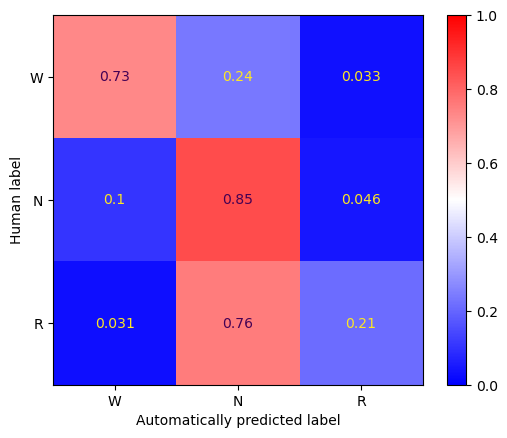

In [49]:
#full evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
y_true = results['human_labeled'].dropna()
y_pred = results['sleep'].dropna()
# Example true labels and predicted labels for a multiclass classification problem

# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_true, y_pred, average=None, labels = ['W','N','R'])
recall_per_class = recall_score(y_true, y_pred, average=None)
f1_per_class = f1_score(y_true, y_pred, average=None)

accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy}\n')

# # Print class-wise metrics
print("Class-wise Metrics:")
for i in range(len(precision_per_class)):
    print("Class {}: Precision={}, Recall={}, F1 Score={}".format(i, precision_per_class[i], recall_per_class[i], f1_per_class[i]))

# # Calculate and print confusion matrix
# plt.set_cmap('bwr')
conf_matrix = confusion_matrix(y_true, y_pred, labels = ['W','N','R'], normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=['W','N','R'])
disp.plot()
disp.ax_.set(xlabel='Automatically predicted label', ylabel='Human label')#('Automatically predicted label')#,ylabel = 'Human label')
disp.ax_.get_images()[0].set_clim(0, 1)
disp.ax_.get_images()[0].set_cmap('bwr')
plt.savefig('plots/conf_matrix.png', dpi = 300, transparent = True)

In [18]:
#now get descriptions
results.groupby('human_labeled').median(numeric_only = True).apply(minmax_scale)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4061824766.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('human_labeled').median(numeric_only = True).apply(minmax_scale)


,delta,theta,alpha,beta,gamma,emg
human_labeled,,,,,,
W,0.000000,0.665794,0.000000,1.000000,1.000000,1.000000
N,1.000000,0.000000,0.675486,0.000000,0.000000,0.089438
R,0.297428,1.000000,1.000000,0.452736,0.020618,0.000000


In [19]:
results.groupby('sleep').median(numeric_only = True).apply(minmax_scale)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\1613924655.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('sleep').median(numeric_only = True).apply(minmax_scale)


,delta,theta,alpha,beta,gamma,emg
sleep,,,,,,
W,0.496701,0.101634,0.000000,0.941831,1.000000,1.000000
N,1.000000,0.000000,0.547124,0.000000,0.000000,0.083524
R,0.000000,1.000000,1.000000,1.000000,0.394978,0.000000


In [20]:
#save to excel
results.groupby('human_labeled').median(numeric_only = True).apply(minmax_scale).to_excel('results/human_labeled_state_params.xlsx')
results.groupby('sleep').median(numeric_only = True).apply(minmax_scale).to_excel('results/clusterer_state_params.xlsx')

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\1825186508.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('human_labeled').median(numeric_only = True).apply(minmax_scale).to_excel('results/human_labeled_state_params.xlsx')
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\1825186508.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('sleep').median(numeric_only = True).apply(minmax_scale).to_excel('results/clusterer_state_params.xlsx')


In [21]:
#count
results.groupby('human_labeled').count()/len(results)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\590274580.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('human_labeled').count()/len(results)


,delta,theta,alpha,beta,gamma,emg,cluster,sleep,id
human_labeled,,,,,,,,,
W,0.495587,0.495587,0.495587,0.495587,0.495587,0.495587,0.495587,0.495587,0.495587
N,0.445756,0.445756,0.445756,0.445756,0.445756,0.445756,0.445756,0.445756,0.445756
R,0.058657,0.058657,0.058657,0.058657,0.058657,0.058657,0.058657,0.058657,0.058657


In [22]:
#count
results.groupby('sleep').count()/len(results)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\2585443712.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results.groupby('sleep').count()/len(results)


,delta,theta,alpha,beta,gamma,emg,cluster,human_labeled,id
sleep,,,,,,,,,
W,0.409739,0.409739,0.409739,0.409739,0.409739,0.409739,0.409739,0.409739,0.409739
N,0.540944,0.540944,0.540944,0.540944,0.540944,0.540944,0.540944,0.540944,0.540944
R,0.049317,0.049317,0.049317,0.049317,0.049317,0.049317,0.049317,0.049317,0.049317


In [23]:
#save to excel
(results.groupby('human_labeled').count()/len(results)).to_excel('results/human_labeled_counts.xlsx')
(results.groupby('sleep').count()/len(results)).to_excel('results/clusterer_counts.xlsx')

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\3861831918.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (results.groupby('human_labeled').count()/len(results)).to_excel('results/human_labeled_counts.xlsx')
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\3861831918.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  (results.groupby('sleep').count()/len(results)).to_excel('results/clusterer_counts.xlsx')


In [24]:
#get state durations and counts
results

,delta,theta,alpha,beta,gamma,emg,cluster,sleep,human_labeled,id
0,0.189975,-0.311082,-0.408021,-0.561985,-0.182460,0.016724,1,W,W,oBleu_180626
1,0.189975,-0.311082,-0.408021,-0.561985,-0.182460,0.016724,1,W,W,oBleu_180626
2,0.189975,-0.311082,-0.408021,-0.561985,-0.182460,0.016724,1,W,W,oBleu_180626
3,0.189975,-0.311082,-0.408021,-0.561985,-0.182460,0.016724,1,W,W,oBleu_180626
4,0.189975,-0.311082,-0.408021,-0.561985,-0.182460,0.016724,1,W,W,oBleu_180626
...,...,...,...,...,...,...,...,...,...,...
21589,1.510209,-1.125592,-1.631699,-1.504847,-0.273446,0.373239,30,N,N,Gouda_180708
21590,1.219368,-1.103738,-1.615664,-1.458038,-0.267864,0.373239,30,N,N,Gouda_180708
21591,1.032138,-1.125592,-1.599272,-1.383770,-0.238062,0.373239,30,N,N,Gouda_180708
21592,1.032138,-1.125592,-1.599272,-1.383770,-0.238062,0.373239,30,N,N,Gouda_180708


In [25]:
durations_human = []
for id in results['id'].unique():
    duration_analysis = results.loc[results['id']==id].drop(['delta','theta','alpha','beta','gamma', 'emg'], axis = 1)
    duration_analysis['sleep_numeric'] = duration_analysis['human_labeled'].replace({'W':0,'N':1, 'R':2}).astype(int)
    duration_analysis['diff'] = duration_analysis['sleep_numeric'].diff()
    state_switches = duration_analysis.loc[(duration_analysis['diff']!=0)]
    state_switches['duration'] = 0
    state_switches['duration'].iloc[0:-1] = state_switches.index.to_series().diff().dropna().to_numpy()#already in s from previous analysis
    state_switches['id'] = id
    durations_human.append(state_switches)
durations_human = pd.concat(durations_human)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4050537657.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  duration_analysis['sleep_numeric'] = duration_analysis['human_labeled'].replace({'W':0,'N':1, 'R':2}).astype(int)
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4050537657.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  duration_analysis['sleep_numeric'] = duration_analysis['human_labeled'].replace({'W':0,'N':1, 'R':2}).astype(int)
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4050537657.py:7: SettingWithCopyWarning: 
A value

In [26]:
durations_human.groupby('human_labeled').mean(numeric_only=True)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\2921545169.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  durations_human.groupby('human_labeled').mean(numeric_only=True)


,sleep_numeric,diff,duration
human_labeled,,,
W,0.0,-1.160206,27.921704
N,1.0,0.995400,26.019067
R,2.0,1.004167,21.103333


In [27]:
durations_human.groupby('human_labeled').count()/len(durations_human['id'].unique())

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\999822422.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  durations_human.groupby('human_labeled').count()/len(durations_human['id'].unique())


,cluster,sleep,id,sleep_numeric,diff,duration
human_labeled,,,,,,
W,369.75,369.75,369.75,369.75,368.9,369.75
N,369.75,369.75,369.75,369.75,369.6,369.75
R,60.00,60.00,60.00,60.00,60.0,60.00


In [28]:
durations_auto = []
for id in results['id'].unique():
    duration_analysis = results.loc[results['id']==id].drop(['delta','theta','alpha','beta','gamma', 'emg'], axis = 1)
    duration_analysis['sleep_numeric'] = duration_analysis['sleep'].replace({'W':0,'N':1, 'R':2}).astype(int)
    duration_analysis['diff'] = duration_analysis['sleep_numeric'].diff()
    state_switches = duration_analysis.loc[(duration_analysis['diff']!=0)]
    state_switches['duration'] = 0
    state_switches['duration'].iloc[0:-1] = state_switches.index.to_series().diff().dropna().to_numpy()#already in s from previous analysis
    state_switches['id'] = id
    durations_auto.append(state_switches)
durations_auto = pd.concat(durations_auto)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4048760255.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  duration_analysis['sleep_numeric'] = duration_analysis['sleep'].replace({'W':0,'N':1, 'R':2}).astype(int)
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4048760255.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  duration_analysis['sleep_numeric'] = duration_analysis['sleep'].replace({'W':0,'N':1, 'R':2}).astype(int)
C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4048760255.py:7: SettingWithCopyWarning: 
A value is trying to be

In [29]:
durations_auto.groupby('human_labeled').mean(numeric_only=True)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\1539104459.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  durations_auto.groupby('human_labeled').mean(numeric_only=True)


,sleep_numeric,diff,duration
human_labeled,,,
W,0.580966,-0.306973,145.450284
N,0.943084,0.110743,130.318994
R,1.526749,0.539095,40.781893


In [30]:
durations_auto.groupby('human_labeled').count()/len(durations_human['id'].unique())

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\3575574462.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  durations_auto.groupby('human_labeled').count()/len(durations_human['id'].unique())


,cluster,sleep,id,sleep_numeric,diff,duration
human_labeled,,,,,,
W,70.40,70.40,70.40,70.40,69.55,70.40
N,75.55,75.55,75.55,75.55,75.40,75.55
R,24.30,24.30,24.30,24.30,24.30,24.30


In [31]:
#correct
correct = results.loc[results['sleep']==results['human_labeled']]
#sleep params where my classification was incorrect
correct.groupby('human_labeled').median(numeric_only=True).apply(minmax_scale)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\3375065095.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correct.groupby('human_labeled').median(numeric_only=True).apply(minmax_scale)


,delta,theta,alpha,beta,gamma,emg
human_labeled,,,,,,
W,0.453615,0.100151,0.0000,0.978561,1.000000,1.000000
N,1.000000,0.000000,0.6165,0.000000,0.000000,0.093166
R,0.000000,1.000000,1.0000,1.000000,0.356905,0.000000


In [32]:
#figure out where my method makes mistakes
mistakes = results.loc[results['sleep']!=results['human_labeled']]
#sleep params where my classification was incorrect
mistakes.groupby('human_labeled').median(numeric_only=True).apply(minmax_scale)

C:\Users\marty\AppData\Local\Temp\ipykernel_20316\4198683085.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mistakes.groupby('human_labeled').median(numeric_only=True).apply(minmax_scale)


,delta,theta,alpha,beta,gamma,emg
human_labeled,,,,,,
W,0.428007,0.467996,1.000000,0.450957,0.355433,0.271912
N,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
R,1.000000,0.000000,0.295261,0.000000,0.000000,0.000000


In [33]:
#plot - single rat
rats = results['id'].unique()
rat = rats[0]
single_rat = results[results['id']==rat]

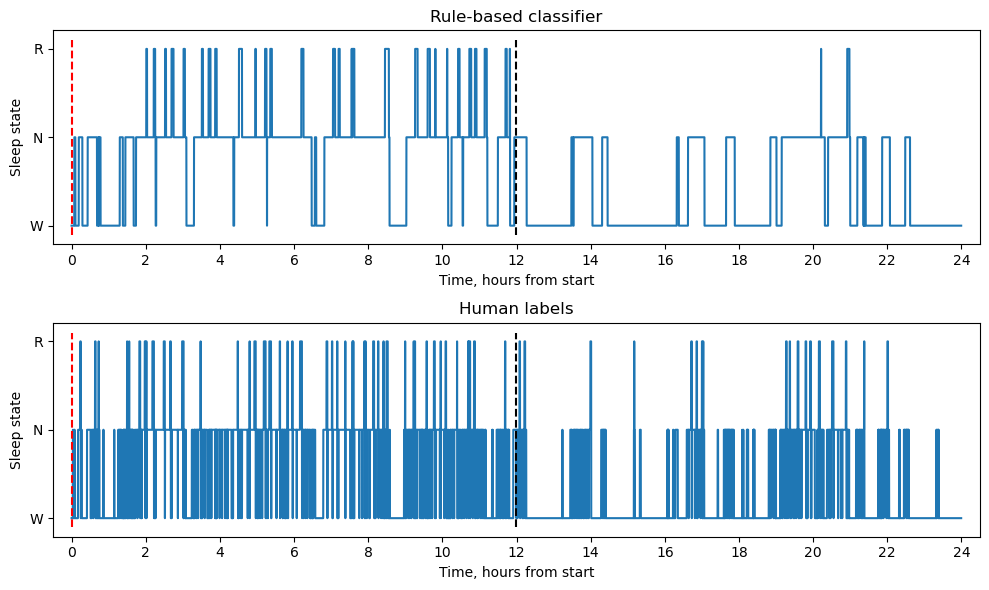

In [34]:
fig, axs = plt.subplots(2,1,figsize=(10,6))
time = np.arange(0,len(single_rat))/(15*60)
axs[0].plot(time, single_rat['sleep'])
axs[0].set(title = 'Rule-based classifier', xlabel = 'Time, hours from start', ylabel = 'Sleep state', xlim = (-0.5,24.5))
ymin, ymax = axs[0].get_ylim()
axs[0].vlines(time[int(np.floor(len(time)/2))], ymin, ymax, color = 'k', linestyles = '--')
axs[0].vlines(time[0], ymin, ymax, color = 'r', linestyles = '--')
axs[0].locator_params(axis = 'x', nbins = 24)

axs[1].plot(time, single_rat['human_labeled'])
axs[1].set(title = 'Human labels', xlabel = 'Time, hours from start', ylabel = 'Sleep state', xlim = (-0.5,24.5))
ymin, ymax = axs[1].get_ylim()
axs[1].vlines(time[int(np.floor(len(time)/2))], ymin, ymax, color = 'k', linestyles = '--')
axs[1].vlines(time[0], ymin, ymax, color = 'r', linestyles = '--')
axs[1].locator_params(axis = 'x', nbins = 24)

plt.tight_layout()
plt.savefig('./plots/classifiervshuman.png')
plt.show()

In [35]:
bool_cat = CategoricalDtype(categories = ['Yes','No'], ordered=True)

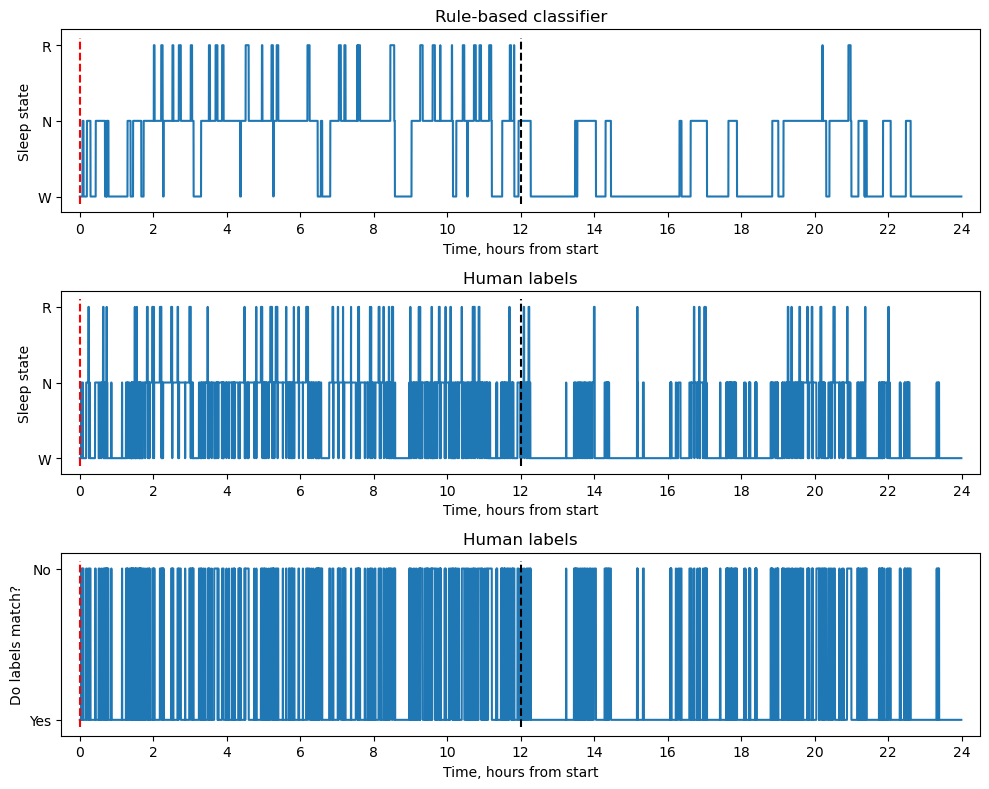

In [36]:
#now check where mistakes happens
fig, axs = plt.subplots(3,1,figsize=(10,8))
time = np.arange(0,len(single_rat))/(15*60)
axs[0].plot(time, single_rat['sleep'])
axs[0].set(title = 'Rule-based classifier', xlabel = 'Time, hours from start', ylabel = 'Sleep state', xlim = (-0.5,24.5))
ymin, ymax = axs[0].get_ylim()
axs[0].vlines(time[int(np.floor(len(time)/2))], ymin, ymax, color = 'k', linestyles = '--')
axs[0].vlines(time[0], ymin, ymax, color = 'r', linestyles = '--')
axs[0].locator_params(axis = 'x', nbins = 24)

axs[1].plot(time, single_rat['human_labeled'])
axs[1].set(title = 'Human labels', xlabel = 'Time, hours from start', ylabel = 'Sleep state', xlim = (-0.5,24.5))
ymin, ymax = axs[1].get_ylim()
axs[1].vlines(time[int(np.floor(len(time)/2))], ymin, ymax, color = 'k', linestyles = '--')
axs[1].vlines(time[0], ymin, ymax, color = 'r', linestyles = '--')
axs[1].locator_params(axis = 'x', nbins = 24)

axs[2].plot(time, (single_rat['human_labeled']==single_rat['sleep']).replace({True:'Yes',False:'No'}).astype(bool_cat))
axs[2].set(title = 'Human labels', xlabel = 'Time, hours from start', ylabel = 'Do labels match?', xlim = (-0.5,24.5))
ymin, ymax = axs[2].get_ylim()
axs[2].vlines(time[int(np.floor(len(time)/2))], ymin, ymax, color = 'k', linestyles = '--')
axs[2].vlines(time[0], ymin, ymax, color = 'r', linestyles = '--')
axs[2].locator_params(axis = 'x', nbins = 24)

plt.tight_layout()
plt.savefig('./plots/classifiervshumanwithdiff.png')
plt.show()

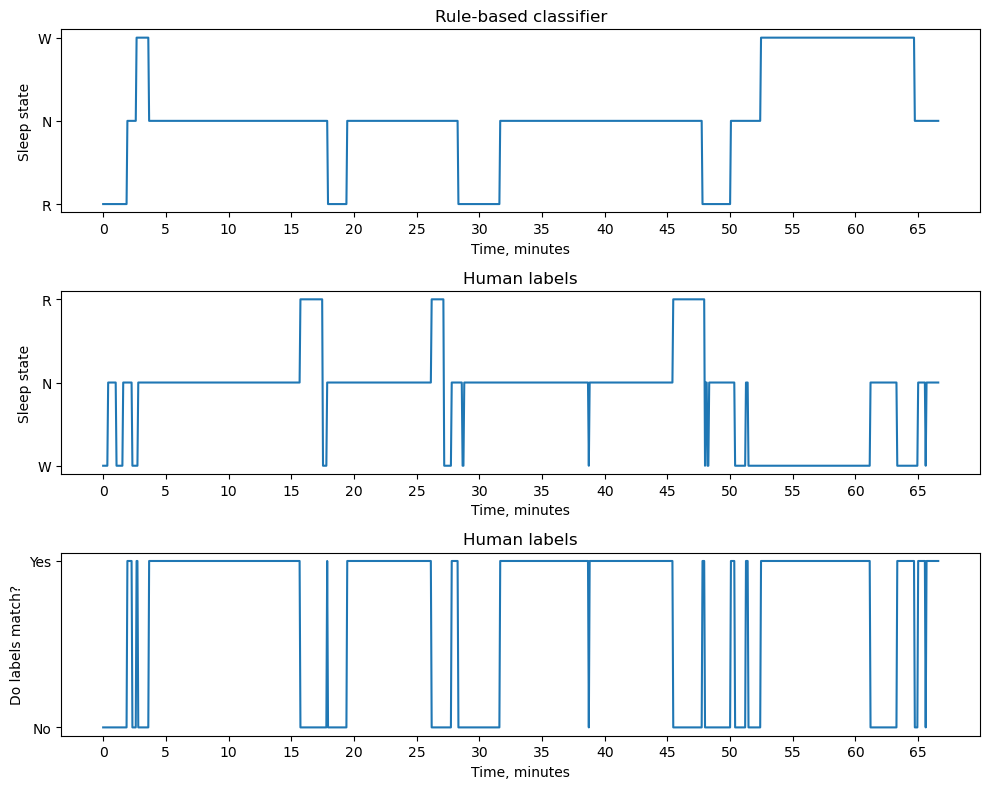

In [38]:
#now check where mistakes happens
single_hour = single_rat.iloc[2000:3000]
fig, axs = plt.subplots(3,1,figsize=(10,8))
time = np.arange(0,len(single_hour))/(15)
axs[0].plot(time, single_hour['sleep'])
axs[0].set(title = 'Rule-based classifier', xlabel = 'Time, minutes', ylabel = 'Sleep state')#, xlim = (-0.5,24.5))
axs[0].locator_params(axis = 'x', nbins = 24)

axs[1].plot(time, single_hour['human_labeled'])
axs[1].set(title = 'Human labels', xlabel = 'Time, minutes', ylabel = 'Sleep state')#, xlim = (-0.5,24.5))
axs[1].locator_params(axis = 'x', nbins = 24)

axs[2].plot(time, (single_hour['human_labeled']==single_hour['sleep']).replace({True:'Yes',False:'No'}).astype(bool_cat))
axs[2].set(title = 'Human labels', xlabel = 'Time, minutes', ylabel = 'Do labels match?')#, xlim = (-0.5,24.5))
axs[2].locator_params(axis = 'x', nbins = 24)

plt.tight_layout()
plt.savefig('./plots/classifiervshumanwithdiffsinglehour.png')
plt.show()